In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


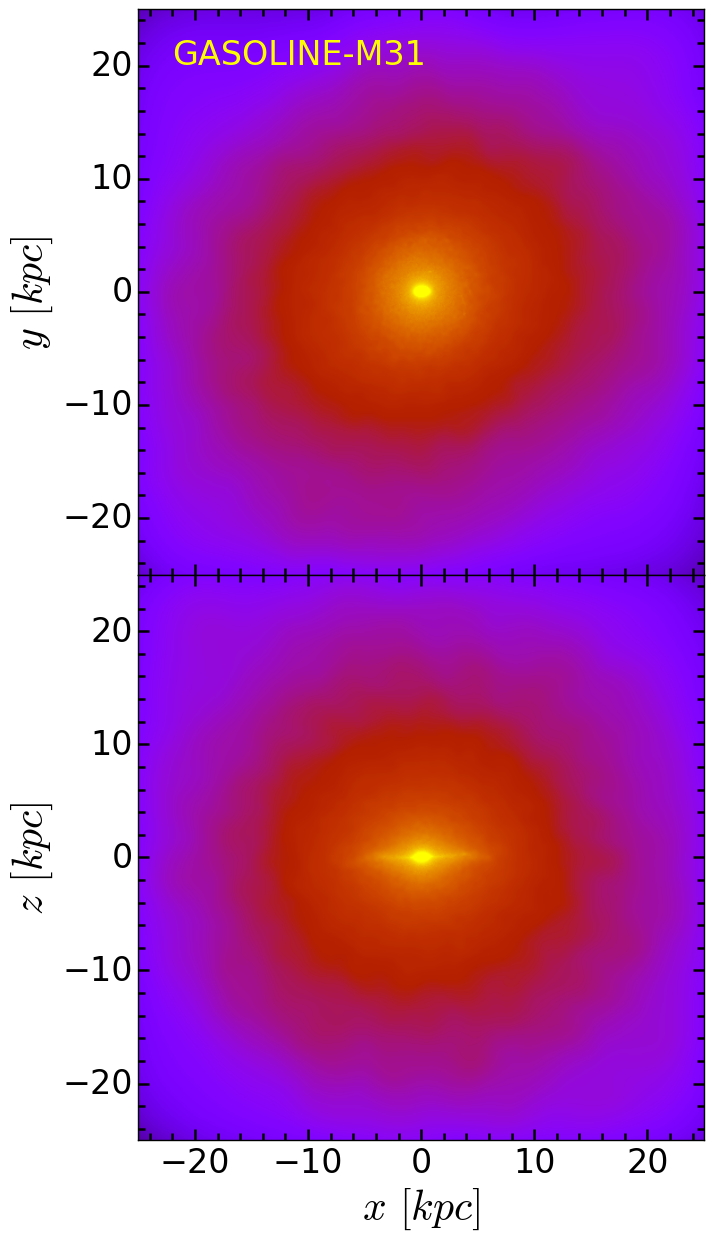

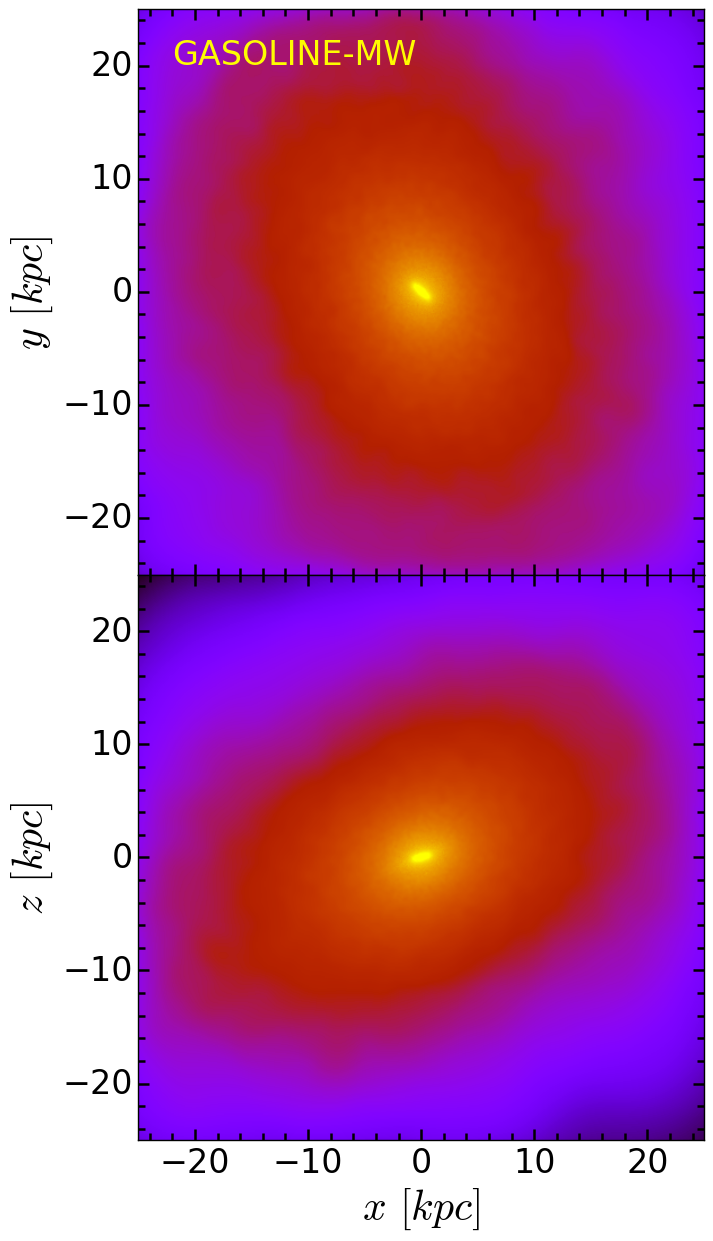

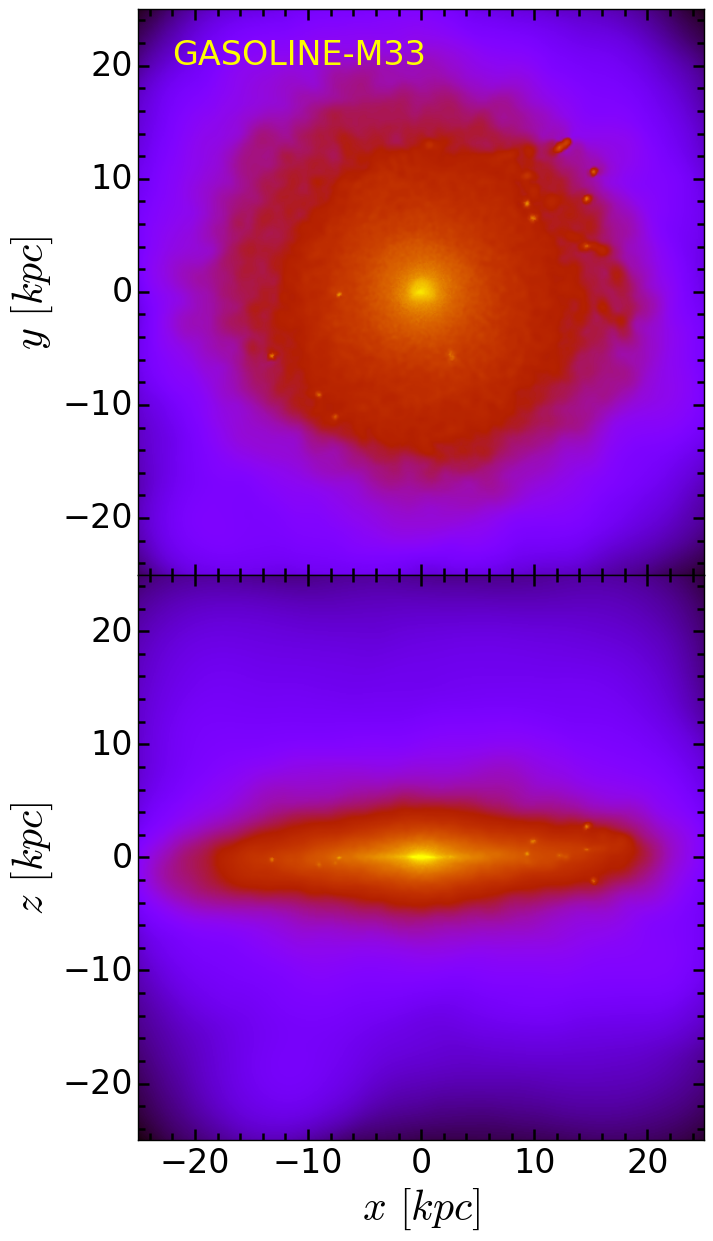

In [6]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np


a0=1
vector2 = ('M31','MW','M33')
vector = (1,2,4)

snap = h5py.File('../outputs2/snap_1024.h5py', 'r')

for i in range(0,3):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
    h = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value

    pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
    masa_str = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[:,0]-cm[0]
    ystr = pstr[:,1]-cm[1]
    zstr = pstr[:,2]-cm[2]
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0]
    v_y = vel[:,1]
    v_z = vel[:,2]

#----------------------masas----------------------------
    r200 = r200*aexp
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

#------------------masa total en r200 (Mvir)--------------------------         
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    pos=np.ndarray([3,np.size(xn)])
    pos[0,:]=xn
    pos[1,:]=yn
    pos[2,:]=zn

#---------------------generador del gráfico-----------------
    rl=25    
    corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))

#-----rango que tiene la escala  de colores-----
    vmin=1
    vmax=7

# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
    cmap='gnuplot'

#-----grafico-----------
    fig=plt.figure(1,figsize=(8,13))
    fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0.03, hspace= 0)

    particles=sph.Particles(pos[:,corte],masa_str[corte],nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax1=fig.add_subplot(211)
    plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    #plt.axis('off')
    #ax1.set_title('Gasoline - '+ str('%s'%vector2[i]), fontsize=18)
    ax1.set_xticklabels([])
    #plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
    plt.ylabel('$y$'+' $[kpc]$', fontsize=30)
    ax1.minorticks_on()
    ax1.tick_params( labelsize=24)
    ax1.tick_params('both', length=5, width=1.8,which='minor')
    ax1.tick_params('both', length=8, width=1.8,which='major')
    plt.text(-22, 21,'GASOLINE-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center') 
    #plt.text(-13, 13, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top') 
             #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
    #plt.annotate("",xy=(30, -62), xycoords='data',xytext=(60, -62),textcoords='data',
    #              ha='center', va='center', 
    #             arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=1.5))

    #plt.text(45, -62, '30 kpc', fontsize=15, color='white', ha='center', va='bottom')


    particles=sph.Particles(pos[:,corte],masa_str[corte],nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90)
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax2=fig.add_subplot(212)
    plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    #plt.axis('off')
    plt.xlabel('$x$'+' $[kpc]$', fontsize=30)
    plt.ylabel('$z$'+' $[kpc]$', fontsize=30)
    ax2.minorticks_on()
    ax2.tick_params( labelsize=24)
    ax2.tick_params('both', length=5, width=1.8,which='minor')
    ax2.tick_params('both', length=8, width=1.8,which='major')
    #plt.text(12.5, 12.5, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top') 


    #fig.savefig('/home/ornela/python/sem1/M31_3/'+str('%03d'%isnap)+'-sh0'+str('%s'%vector[i])+'.png', facecolor= 'k', edgecolor='k', frameon= 'False',bbox_inches='tight',pad_inches=0, dpi = 100)
    fig.savefig('/z/dalgorry/plots2/starGS_'+str('%s'%vector2[i])+'.png', dpi = 100)
    plt.show()
    #plt.clf()



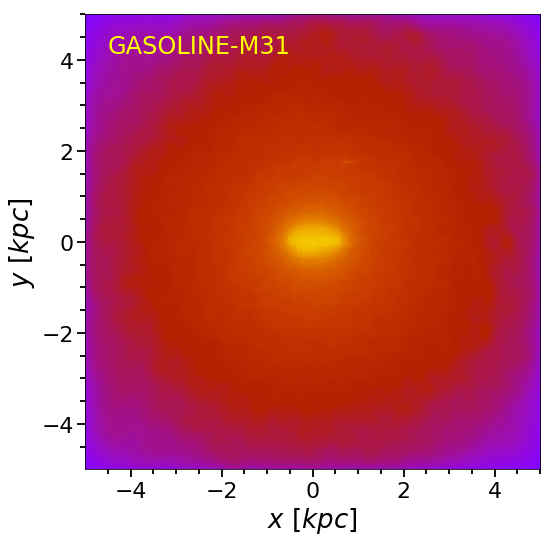

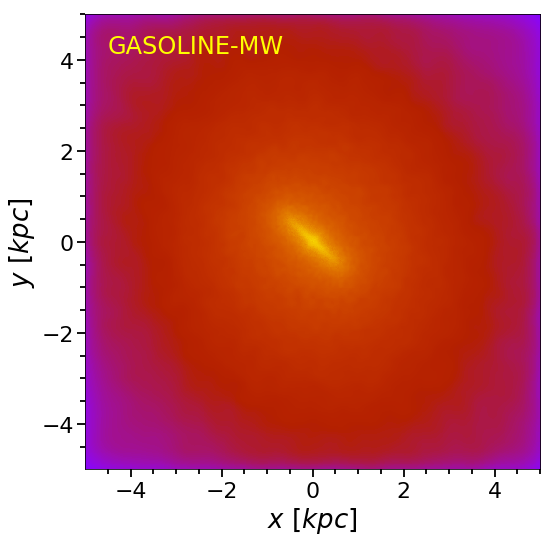

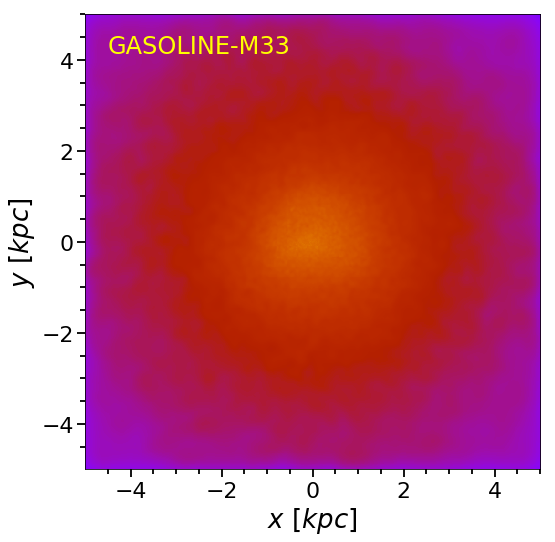

In [18]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np


a0=1
vector2 = ('M31','MW','M33')
vector = (1,2,4)

snap = h5py.File('../outputs2/snap_1024.h5py', 'r')

for i in range(0,3):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
    h = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
   
    pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
    masa_str = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    
#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[:,0]-cm[0]
    ystr = pstr[:,1]-cm[1]
    zstr = pstr[:,2]-cm[2]
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0]
    v_y = vel[:,1]
    v_z = vel[:,2]
#----------------------masas----------------------------
    r200 = r200*aexp
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

#------------------masa total en r200 (Mvir)--------------------------         
    corte,=np.where(r<r90[-1])
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    pos=np.ndarray([3,np.size(xn)])
    pos[0,:]=xn
    pos[1,:]=yn
    pos[2,:]=zn

#---------------------generador del gráfico-----------------
    rl=5    
    corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))

#-----rango que tiene la escala  de colores-----
    vmin=1
    vmax=7

# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
    cmap='gnuplot'

#-----grafico-----------
    fig=plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

    particles=sph.Particles(pos[:,corte],masa_str[corte],nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax1=fig.add_subplot(111)
    plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    #plt.axis('off')
    #ax1.set_title('Gasoline - '+ str('%s'%vector2[i]), fontsize=18)
    #ax1.set_xticklabels([])
    plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
    plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
    ax1.minorticks_on()
    ax1.tick_params( labelsize=22)
    ax1.tick_params('both', length=5, width=1.8,which='minor')
    ax1.tick_params('both', length=8, width=1.8,which='major')
    plt.text(-4.5, 4.3,'GASOLINE-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center') 
    #plt.text(-22, 21,'GASOLINE-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center')
    #plt.text(-13, 13, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top') 
             #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
    #plt.annotate("",xy=(30, -62), xycoords='data',xytext=(60, -62),textcoords='data',
    #              ha='center', va='center', 
    #             arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=1.5))

    #plt.text(45, -62, '30 kpc', fontsize=15, color='white', ha='center', va='bottom')

#     fig.savefig('/z/dalgorry/plots2/starGS_'+str('%s'%vector2[i])+'zoom.png', dpi = 100)
    plt.show()
    #plt.clf()



In [6]:
#funcion conv para pasar tiempo de redshift a Gyr
import numpy as np

def conv(z, h, omega_lambda, omega_matter):

    H0=100*h
#conversion Mpc --> km
    conv1=1./(1e6*206265*1.496e8)
#conversion de s --> Gyr
    conv2=3600*24*365.25*1e9
    H0=H0*conv1*conv2

    c1=np.sqrt(omega_lambda*(1.+z)**(-3.))+np.sqrt((omega_lambda*(1.+z)**(-3.))+omega_matter)
    ln=np.log(c1/np.sqrt(omega_matter))
    c2=2./(3.*np.sqrt(omega_lambda))
        
    time = (1./H0)*c2*ln

    return time

In [5]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np


a0=1
vector2 = ('M31','MW','M33')
vector = (1,2,4)
snapshot = np.loadtxt('/z/dalgorry/snapshots.txt', dtype='string')

for j in range(len(snapshot)-1,0,-1):
    snap = h5py.File('../outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    print j, snapshot[j]

    for i in range(0,3):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
        h = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value

        pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        masa_str = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = pstr[:,0]-cm[0]
        ystr = pstr[:,1]-cm[1]
        zstr = pstr[:,2]-cm[2]
        r = np.sqrt(xstr**2+ystr**2+zstr**2)

        v_x = vel[:,0]
        v_y = vel[:,1]
        v_z = vel[:,2]

    #----------------------masas----------------------------
        r200 = r200*aexp
        rgal=0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])

        Mc_str = cumsum((masa_str[limit])[r_indice])
        M_gal = Mc_str[-1]

    #------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
        M90 = Mc_str[noventa]                

    #------------------masa total en r200 (Mvir)--------------------------         
        veloc,=np.where(r<r50[-1])

    #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
        vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
        vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm

        if np.float(snapshot[j]) == 1024:
            e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        pos=np.ndarray([3,np.size(xn)])
        pos[0,:]=xn
        pos[1,:]=yn
        pos[2,:]=zn

    #---------------------generador del gráfico-----------------
        rl=50    
        corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))

    #-----rango que tiene la escala  de colores-----
        vmin=1
        vmax=7

    # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='gnuplot'

    #-----grafico-----------
        fig=plt.figure(1,figsize=(8,8))
        fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

        particles=sph.Particles(pos[:,corte],masa_str[corte],nb=50)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax1=fig.add_subplot(111)
        plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        #plt.axis('off')
        #ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        #plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
        #plt.ylabel('$y$'+' $[kpc]$', fontsize=30)
        ax1.minorticks_on()
        ax1.tick_params( labelsize=24)
        ax1.tick_params('both', length=5, width=1.8,which='minor')
        ax1.tick_params('both', length=8, width=1.8,which='major')
        plt.text(-47, 45,'GASOLINE-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center') 
                 #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
        plt.annotate("",xy=(20, -47), xycoords='data',xytext=(45, -47),textcoords='data',
                      ha='center', va='center', 
                     arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=2.5))

        plt.text(32.5, -47, '25 kpc', fontsize=24, color='white', ha='center', va='bottom')
        plt.text(-45, -45, str('%.3f'%time)+'Gyr', fontsize=24, color='white', ha='left', va='center')


        '''particles=sph.Particles(pos[:,corte],masa_str[corte],nb=50)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax2=fig.add_subplot(212)
        plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        #plt.axis('off')
        plt.xlabel('$x$'+' $[kpc]$', fontsize=30)
        plt.ylabel('$z$'+' $[kpc]$', fontsize=30)
        ax2.minorticks_on()
        ax2.tick_params( labelsize=24)
        ax2.tick_params('both', length=5, width=1.8,which='minor')
        ax2.tick_params('both', length=8, width=1.8,which='major')
        #plt.text(12.5, 12.5, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top')''' 


        fig.savefig('/z/dalgorry/plots3/'+str('%s'%vector2[i])+'_str_faceon/'+str('%s'%snapshot[j])+'-'+str('%s'%vector2[i])+'.png', facecolor= 'k', edgecolor='k', frameon= 'False',bbox_inches='tight',pad_inches=0, dpi = 100)
        #fig.savefig('/z/dalgorry/plots2/starGS_'+str('%s'%vector2[i])+'.png', dpi = 100)
        #plt.show()
        plt.clf()

59 1024
58 1008
57 0992
56 0976
55 0960
54 0944
53 0928
52 0912
51 0896
50 0880
49 0864
48 0848
47 0832
46 0816
45 0800
44 0784
43 0768
42 0752
41 0736
40 0720
39 0704
38 0688
37 0672
36 0656
35 0640
34 0624
33 0608
32 0592
31 0576
30 0560
29 0544
28 0528
27 0512
26 0496
25 0480
24 0464
23 0453
22 0448
21 0432
20 0416
19 0400
18 0384
17 0368
16 0352
15 0336
14 0320
13 0304
12 0288
11 0272
10 0256
9 0240
8 0224
7 0208
6 0192
5 0176
4 0160
3 0144
2 0128
1 0112


In [9]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np


a0=1
vector2 = ('M31','MW','M33')
vector = (1,2,4)
snapshot = np.loadtxt('/z/dalgorry/snapshots.txt', dtype='string')

for j in range(len(snapshot)-1,0,-1):
    snap = h5py.File('../outputs2/snap_'+str('%s'%snapshot[j])+'.h5py', 'r')
    print j, snapshot[j]

    for i in range(0,3):
        cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
        r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
        time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
        aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
        h = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value

        pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
        masa_str = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
        vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    #---aca paso las coordenadas respecto al centro de la galaxia------
        xstr = pstr[:,0]-cm[0]
        ystr = pstr[:,1]-cm[1]
        zstr = pstr[:,2]-cm[2]
        r = np.sqrt(xstr**2+ystr**2+zstr**2)

        v_x = vel[:,0]
        v_y = vel[:,1]
        v_z = vel[:,2]

    #----------------------masas----------------------------
        r200 = r200*aexp
        rgal=0.15*r200

        limit = np.where(r<rgal)
        r_sort = np.sort(r[limit])
        r_indice = np.argsort(r[limit])

        Mc_str = cumsum((masa_str[limit])[r_indice])
        M_gal = Mc_str[-1]

    #------------------ calculamos M90------------------------------------------
        razon = Mc_str/M_gal
        noventa, = np.where(razon < 0.9)
        cincuenta, = np.where(razon < 0.5)

        r90 = r_sort[noventa]
        r50 = r_sort[cincuenta]
        M90 = Mc_str[noventa]                

    #------------------masa total en r200 (Mvir)--------------------------         
        veloc,=np.where(r<r50[-1])

    #----------componentes de la velocidad del centro de masa------------
        vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
        vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
        vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
        vx = vel[:,0] - vxcm
        vy = vel[:,1] - vycm
        vz = vel[:,2] - vzcm

        if np.float(snapshot[j]) == 1024:
            e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

    ##posiciones de partículas que se quiere graficar
    ##como lo de arriba me da los versores hago las posiciones con esto 

        xn = e1x*xstr + e1y*ystr + e1z*zstr
        yn = e2x*xstr + e2y*ystr + e2z*zstr
        zn = e3x*xstr + e3y*ystr + e3z*zstr
        vxn = e1x*vx + e1y*vy + e1z*vz
        vyn = e2x*vx + e2y*vy + e2z*vz
        vzn = e3x*vx + e3y*vy + e3z*vz

        pos=np.ndarray([3,np.size(xn)])
        pos[0,:]=xn
        pos[1,:]=yn
        pos[2,:]=zn

    #---------------------generador del gráfico-----------------
        rl=25    
        corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))

    #-----rango que tiene la escala  de colores-----
        vmin=1
        vmax=7

    # ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
        cmap='gnuplot'

    #-----grafico-----------
        fig=plt.figure(1,figsize=(8,8))
        fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

        particles=sph.Particles(pos[:,corte],masa_str[corte],nb=50)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax1=fig.add_subplot(111)
        plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        #plt.axis('off')
        #ax1.set_title('Gadget - '+ str('%s'%vector2[i]), fontsize=18)
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        #plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
        #plt.ylabel('$y$'+' $[kpc]$', fontsize=30)
        ax1.minorticks_on()
        ax1.tick_params( labelsize=24)
        ax1.tick_params('both', length=5, width=1.8,which='minor')
        ax1.tick_params('both', length=8, width=1.8,which='major')
        plt.text(-22, 20,'GASOLINE-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center') 
                 #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
        plt.annotate("",xy=(10, -22), xycoords='data',xytext=(20, -22),textcoords='data',
                      ha='center', va='center', 
                     arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=2.5))

        plt.text(7.5, -22, '10 kpc', fontsize=24, color='white', ha='center', va='bottom')
        plt.text(-20, -20, str('%.3f'%time)+'Gyr', fontsize=24, color='white', ha='left', va='center')


        '''particles=sph.Particles(pos[:,corte],masa_str[corte],nb=50)
        escena=sph.Scene(particles)
        escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], t=90)
        rend=sph.Render(escena)
        extent=escena.get_extent()
        rend.set_logscale()

        ax2=fig.add_subplot(212)
        plt.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
        #plt.axis('off')
        plt.xlabel('$x$'+' $[kpc]$', fontsize=30)
        plt.ylabel('$z$'+' $[kpc]$', fontsize=30)
        ax2.minorticks_on()
        ax2.tick_params( labelsize=24)
        ax2.tick_params('both', length=5, width=1.8,which='minor')
        ax2.tick_params('both', length=8, width=1.8,which='major')
        #plt.text(12.5, 12.5, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top')''' 


        fig.savefig('/z/dalgorry/plots3/'+str('%s'%vector2[i])+'_str/'+str('%s'%snapshot[j])+'-'+str('%s'%vector2[i])+'.png', facecolor= 'k', edgecolor='k', frameon= 'False',bbox_inches='tight',pad_inches=0, dpi = 100)
        #fig.savefig('/z/dalgorry/plots2/starGS_'+str('%s'%vector2[i])+'.png', dpi = 100)
        #plt.show()
        plt.clf()

59 1024
58 1008
57 0992
56 0976
55 0960
54 0944
53 0928
52 0912
51 0896
50 0880
49 0864
48 0848
47 0832
46 0816
45 0800
44 0784
43 0768
42 0752
41 0736
40 0720
39 0704
38 0688
37 0672
36 0656
35 0640
34 0624
33 0608
32 0592
31 0576
30 0560
29 0544
28 0528
27 0512
26 0496
25 0480
24 0464
23 0453
22 0448
21 0432
20 0416
19 0400
18 0384
17 0368
16 0352
15 0336
14 0320
13 0304
12 0288
11 0272
10 0256
9 0240
8 0224
7 0208
6 0192
5 0176
4 0160
3 0144
2 0128
1 0112


## isodensidades

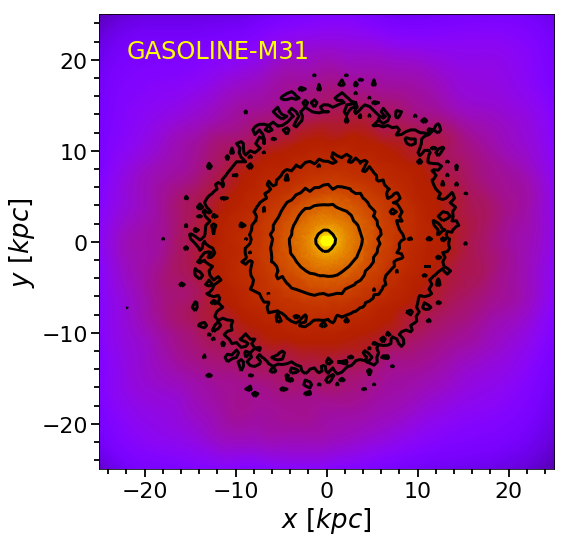

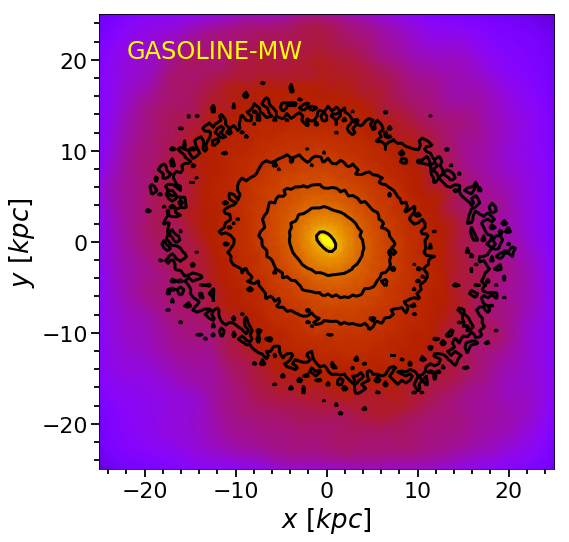

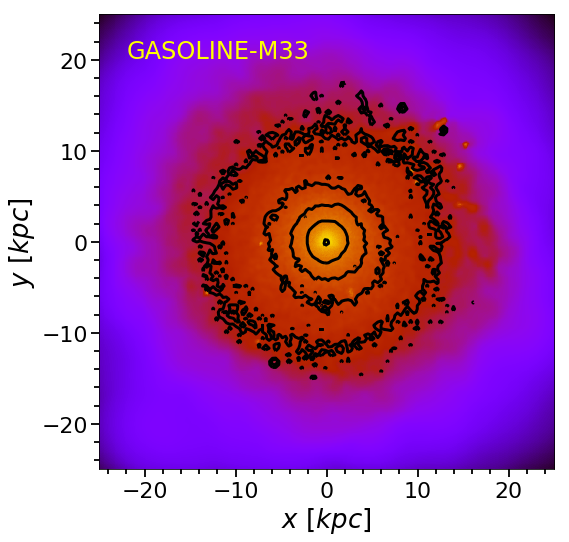

In [12]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np
from matplotlib.colors import LogNorm


a0=1
vector2 = ('M31','MW','M33')
vector = (1,2,4)

snap = h5py.File('../outputs2/snap_1024.h5py', 'r')

for i in range(0,3):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
    h = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
   
    pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
    masa_str = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    
#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[:,0]-cm[0]
    ystr = pstr[:,1]-cm[1]
    zstr = pstr[:,2]-cm[2]
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0]
    v_y = vel[:,1]
    v_z = vel[:,2]
#----------------------masas----------------------------
    r200 = r200*aexp
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

#------------------masa total en r200 (Mvir)--------------------------         
    corte,=np.where(r<r90[-1])
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    bins = 100
    counts,xedges,yedges = histogram2d(xn[limit],yn[limit],bins)

    edges1 = [10,40,120,400,5000,100000]
    
    pos=np.ndarray([3,np.size(xn)])
    pos[0,:]=xn
    pos[1,:]=yn
    pos[2,:]=zn

#---------------------generador del gráfico-----------------
    rl=25    
    corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))

#-----rango que tiene la escala  de colores-----
    vmin=1
    vmax=7

# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
    cmap='gnuplot'

#-----grafico-----------
    fig=plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

    particles=sph.Particles(pos[:,corte],masa_str[corte],nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax1=fig.add_subplot(111)
    ax1.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax1.contour(counts,extent=[xedges.min(),xedges.max(),yedges.min(),yedges.max()], colors ='k',
            linewidths=3, norm=LogNorm(), levels =edges1)
    #plt.axis('off')
    #ax1.set_title('Gasoline - '+ str('%s'%vector2[i]), fontsize=18)
    #ax1.set_xticklabels([])
    plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
    plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
    ax1.minorticks_on()
    ax1.tick_params( labelsize=22)
    ax1.tick_params('both', length=5, width=1.8,which='minor')
    ax1.tick_params('both', length=8, width=1.8,which='major')
    plt.text(-22, 21,'GASOLINE-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center') 
    #plt.text(-22, 21,'GASOLINE-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center')
    #plt.text(-13, 13, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top') 
             #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
    #plt.annotate("",xy=(30, -62), xycoords='data',xytext=(60, -62),textcoords='data',
    #              ha='center', va='center', 
    #             arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=1.5))

    #plt.text(45, -62, '30 kpc', fontsize=15, color='white', ha='center', va='bottom'


    fig.savefig('/z/omarioni/isodens'+ str('%s' %vector[i])+'gs.png', dpi = 100)
    plt.show()
    #plt.clf()


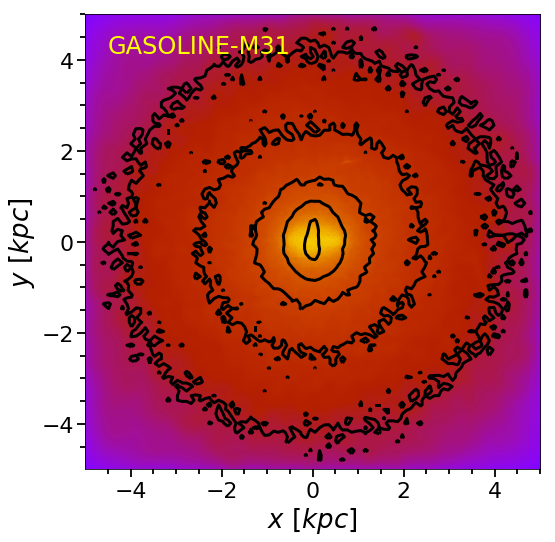

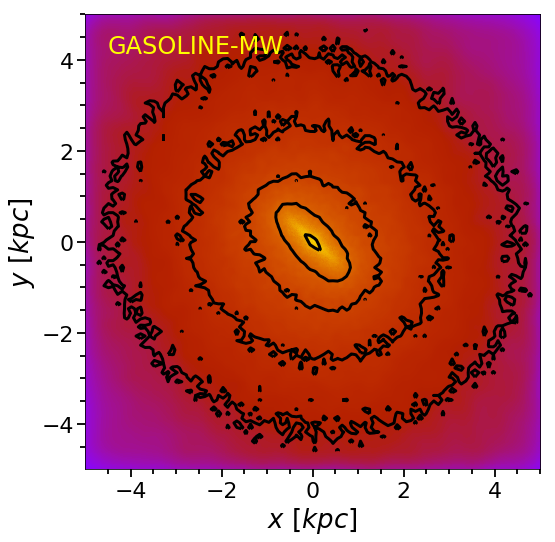

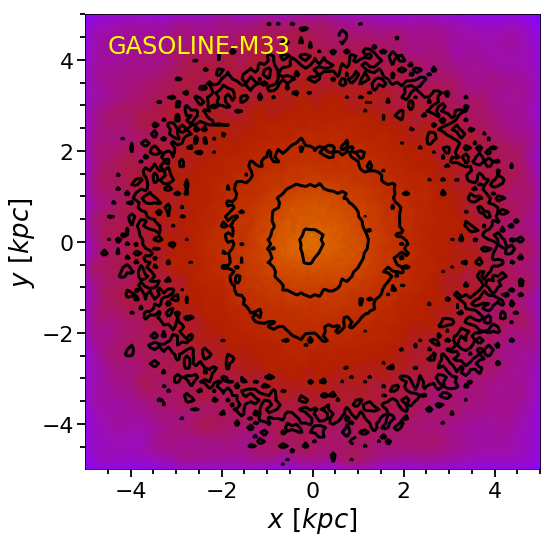

In [14]:
import matplotlib.pyplot as plt
import h5py
import rotation as rot
import sphviewer as sph
import numpy as np
from matplotlib.colors import LogNorm


a0=1
vector2 = ('M31','MW','M33')
vector = (1,2,4)

snap = h5py.File('../outputs2/snap_1024.h5py', 'r')

for i in range(0,3):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value
    h = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
   
    pstr = snap['subhalo_00'+ str('%s'%vector[i]) + '/Str/Coordinates'].value
    masa_str = snap['subhalo_00'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

    
#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = pstr[:,0]-cm[0]
    ystr = pstr[:,1]-cm[1]
    zstr = pstr[:,2]-cm[2]
    r = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0]
    v_y = vel[:,1]
    v_z = vel[:,2]
#----------------------masas----------------------------
    r200 = r200*aexp
    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((masa_str[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa]
    r50 = r_sort[cincuenta]
    M90 = Mc_str[noventa]                

#------------------masa total en r200 (Mvir)--------------------------         
    corte,=np.where(r<r90[-1])
    veloc,=np.where(r<r50[-1])

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(masa_str[veloc]*v_x[veloc])/sum(masa_str[veloc])
    vycm = sum(masa_str[veloc]*v_y[veloc])/sum(masa_str[veloc])
    vzcm = sum(masa_str[veloc]*v_z[veloc])/sum(masa_str[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(masa_str,xstr,ystr,zstr,vx,vy,vz,r90[-1])

##posiciones de partículas que se quiere graficar
##como lo de arriba me da los versores hago las posiciones con esto 

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz
    
    bins = 100
    counts,xedges,yedges = histogram2d(xn[np.where(r<5)],yn[np.where(r<5)],bins)

    edges1 = [10,40,120,400,5000,100000]
    
    pos=np.ndarray([3,np.size(xn)])
    pos[0,:]=xn
    pos[1,:]=yn
    pos[2,:]=zn

#---------------------generador del gráfico-----------------
    rl=5    
    corte,=np.where((xn<rl) & (yn<rl) & (zn<rl) & (xn>-rl) & (yn>-rl) & (zn>-rl))

#-----rango que tiene la escala  de colores-----
    vmin=1
    vmax=7

# ----escala de colores que te guste (http://matplotlib.org/examples/color/colormaps_reference.html)---
    cmap='gnuplot'

#-----grafico-----------
    fig=plt.figure(1,figsize=(8,8))
    fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)

    particles=sph.Particles(pos[:,corte],masa_str[corte],nb=50)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl])
    rend=sph.Render(escena)
    extent=escena.get_extent()
    rend.set_logscale()

    ax1=fig.add_subplot(111)
    ax1.imshow(rend.get_image(),extent=extent,origin='lower',cmap=cmap, vmin=vmin, vmax= vmax)
    ax1.contour(counts,extent=[xedges.min(),xedges.max(),yedges.min(),yedges.max()], colors ='k',
            linewidths=3, norm=LogNorm(), levels =edges1)
    #plt.axis('off')
    #ax1.set_title('Gasoline - '+ str('%s'%vector2[i]), fontsize=18)
    #ax1.set_xticklabels([])
    plt.xlabel('$x$'+' $[kpc]$', fontsize=26)
    plt.ylabel('$y$'+' $[kpc]$', fontsize=26)
    ax1.minorticks_on()
    ax1.tick_params( labelsize=22)
    ax1.tick_params('both', length=5, width=1.8,which='minor')
    ax1.tick_params('both', length=8, width=1.8,which='major')
    plt.text(-4.5, 4.3,'GASOLINE-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center') 
    #plt.text(-22, 21,'GASOLINE-'+'%s'%vector2[i], fontsize=24, color='yellow', ha='left', va='center')
    #plt.text(-13, 13, str('%.3f'%t)+'Gyr', fontsize=22, color='white', ha='left', va='top') 
             #bbox={'facecolor':'black', 'alpha':1, 'pad':2})
    #plt.annotate("",xy=(30, -62), xycoords='data',xytext=(60, -62),textcoords='data',
    #              ha='center', va='center', 
    #             arrowprops=dict(arrowstyle="|-|", connectionstyle='arc3', color ='white', lw=1.5))

    #plt.text(45, -62, '30 kpc', fontsize=15, color='white', ha='center', va='bottom'


    fig.savefig('/z/omarioni/isodens'+ str('%s' %vector[i])+'gs_zoom.png', dpi = 100)
    plt.show()
    #plt.clf()